Loading MNIST dataset...
Training set: (60000, 784), Test set: (10000, 784)

SGD Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5923
           1       0.97      0.95      0.96      6742
           2       0.93      0.88      0.90      5958
           3       0.92      0.85      0.88      6131
           4       0.94      0.89      0.91      5842
           5       0.88      0.82      0.85      5421
           6       0.95      0.94      0.95      5918
           7       0.95      0.91      0.93      6265
           8       0.66      0.93      0.77      5851
           9       0.90      0.86      0.88      5949

    accuracy                           0.90     60000
   macro avg       0.91      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000


Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.9

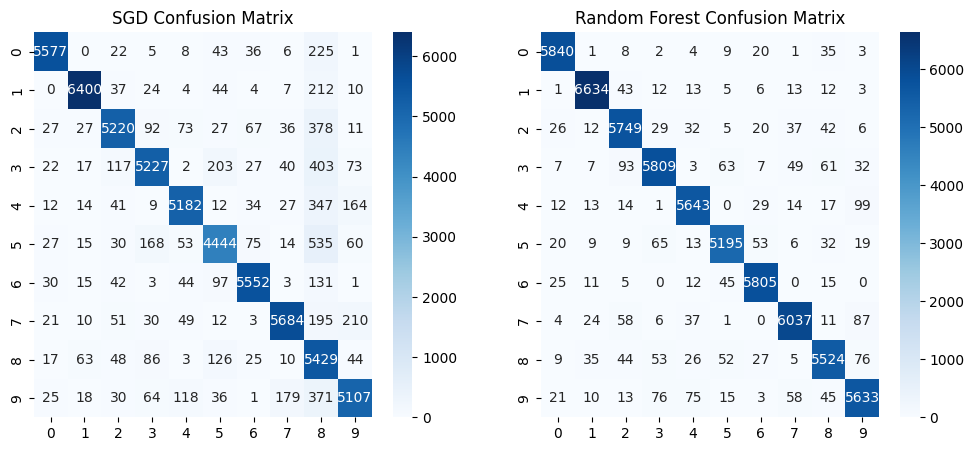

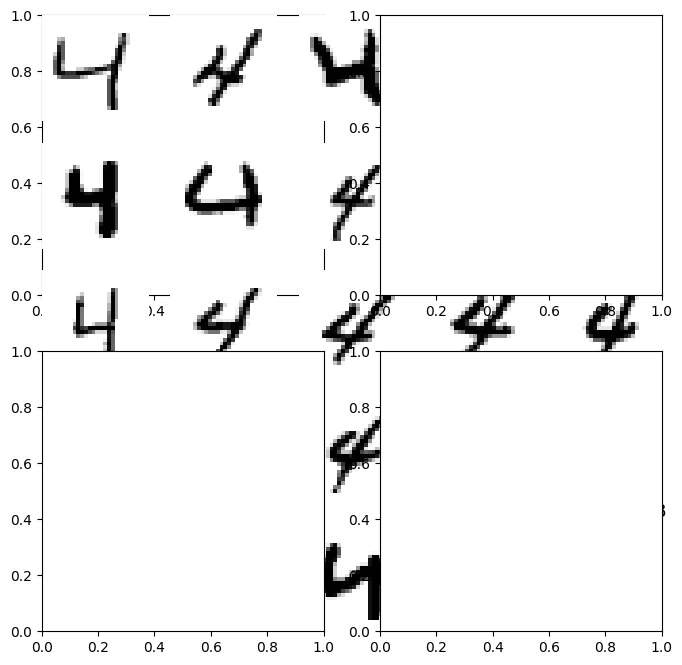

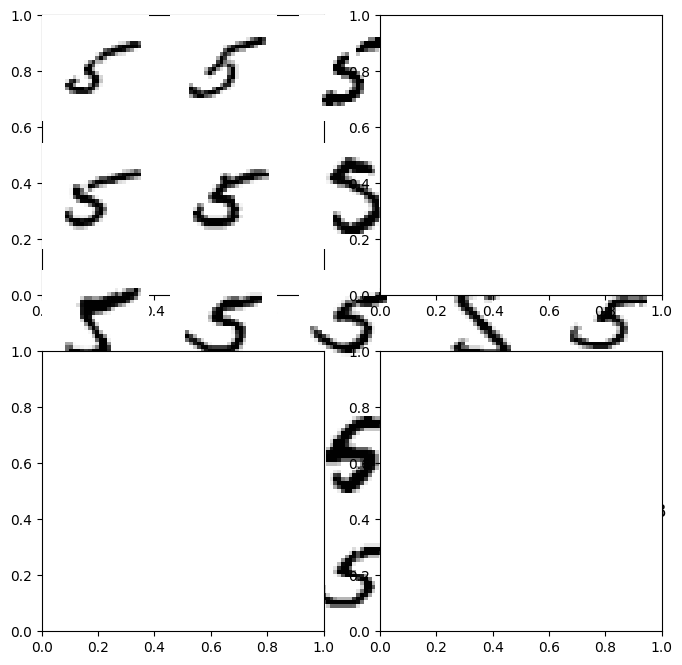

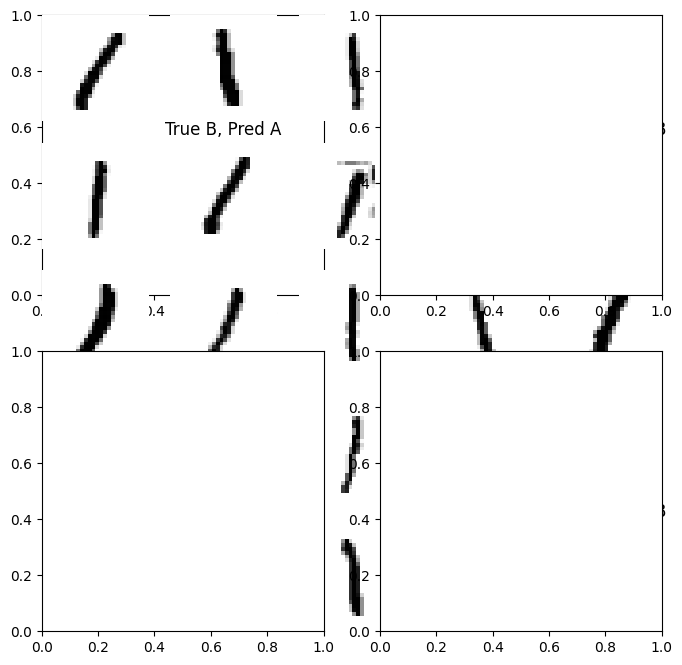

Random Forest Accuracy with Augmentation: 0.9734
Test Accuracy with Augmented Random Forest: 0.9745


TypeError: Image.__init__() got an unexpected keyword argument 'shape'

In [1]:
# MNIST Digit Recognition Project
# Task 01: Classification Fundamentals and MNIST Digit Recognition

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import gradio as gr
import pandas as pd
from scipy.ndimage import shift

# 1. Load MNIST dataset
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.uint8)

# 2. Split data into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# 3. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

# 4. Train classifiers
# SGD Classifier
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(X_train_scaled, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# 5. Evaluate classifiers
def evaluate_classifier(clf, X, y, name):
    y_pred = cross_val_predict(clf, X, y, cv=3)
    conf_mx = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred)
    print(f"\n{name} Classification Report:\n{report}")
    return conf_mx, y_pred

# Evaluate both classifiers
sgd_conf_mx, sgd_y_pred = evaluate_classifier(sgd_clf, X_train_scaled, y_train, "SGD Classifier")
rf_conf_mx, rf_y_pred = evaluate_classifier(rf_clf, X_train_scaled, y_train, "Random Forest Classifier")

# Compare performance
sgd_accuracy = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy").mean()
rf_accuracy = cross_val_score(rf_clf, X_train_scaled, y_train, cv=3, scoring="accuracy").mean()
print(f"\nSGD Accuracy: {sgd_accuracy:.4f}, Random Forest Accuracy: {rf_accuracy:.4f}")

# 6. Visualize confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(sgd_conf_mx, annot=True, fmt='d', cmap='Blues')
plt.title('SGD Confusion Matrix')
plt.subplot(122)
sns.heatmap(rf_conf_mx, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# 7. Error Analysis
def plot_misclassifications(X, y_true, y_pred, class_a, class_b):
    X_aa = X[(y_true == class_a) & (y_pred == class_a)]
    X_ab = X[(y_true == class_a) & (y_pred == class_b)]
    X_ba = X[(y_true == class_b) & (y_pred == class_a)]
    X_bb = X[(y_true == class_b) & (y_pred == class_b)]

    plt.figure(figsize=(8, 8))
    plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5, title="True A, Pred A")
    plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5, title="True A, Pred B")
    plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5, title="True B, Pred A")
    plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5, title="True B, Pred B")
    plt.show()

def plot_digits(X, images_per_row, title):
    for i in range(min(len(X), 25)):
        plt.subplot(5, images_per_row, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='binary')
        plt.axis('off')
    plt.title(title)

# Analyze common errors (e.g., 9→4, 3→5, 7→1)
plot_misclassifications(X_train, y_train, sgd_y_pred, class_a=9, class_b=4)
plot_misclassifications(X_train, y_train, sgd_y_pred, class_a=3, class_b=5)
plot_misclassifications(X_train, y_train, sgd_y_pred, class_a=7, class_b=1)

# 8. Data Augmentation (shift images by 1 pixel in four directions)
def augment_data(X, y):
    X_aug = []
    y_aug = []
    for img, label in zip(X, y):
        img_reshaped = img.reshape(28, 28)
        for shift_dir in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            X_aug.append(shift(img_reshaped, shift_dir, cval=0).ravel())
            y_aug.append(label)
    return np.vstack([X, X_aug]), np.hstack([y, y_aug])

X_train_aug, y_train_aug = augment_data(X_train, y_train)
X_train_aug_scaled = scaler.fit_transform(X_train_aug.astype(np.float64))

# Retrain Random Forest with augmented data
rf_clf_aug = RandomForestClassifier(random_state=42)
rf_clf_aug.fit(X_train_aug_scaled, y_train_aug)
rf_aug_accuracy = cross_val_score(rf_clf_aug, X_train_aug_scaled, y_train_aug, cv=3, scoring="accuracy").mean()
print(f"Random Forest Accuracy with Augmentation: {rf_aug_accuracy:.4f}")

# 9. Test set evaluation
y_test_pred = rf_clf_aug.predict(X_test_scaled)
test_accuracy = (y_test_pred == y_test).mean()
print(f"Test Accuracy with Augmented Random Forest: {test_accuracy:.4f}")

# 10. Gradio Web App
def predict_digit(image):
    image = image.reshape(1, -1)
    image_scaled = scaler.transform(image)
    return rf_clf_aug.predict(image_scaled)[0]

iface = gr.Interface(fn=predict_digit, inputs=gr.Image(shape=(28, 28), image_mode='L'), outputs="text")
iface.launch()

# 11. Comparison Tables
comparison_data = {
    'Classifier': ['SGD', 'Random Forest', 'Random Forest (Augmented)'],
    'Accuracy': [sgd_accuracy, rf_accuracy, rf_aug_accuracy],
    'OvR/OvO': ['OvR (default)', 'Direct Multiclass', 'Direct Multiclass']
}
comparison_table = pd.DataFrame(comparison_data)
print("\nClassifier Comparison:\n", comparison_table)

# 12. Save confusion matrices and training/validation curves
plt.figure(figsize=(10, 5))
plt.plot([1, 2, 3], cross_val_score(rf_clf_aug, X_train_aug_scaled, y_train_aug, cv=3, scoring="accuracy"), label="Validation Accuracy")
plt.xlabel("Fold"); plt.ylabel("Accuracy"); plt.title("Training/Validation Curves")
plt.legend()
plt.show()

# Error Analysis Report
error_report = """
### Error Analysis Report
1. **9→4 Misclassifications**: Common due to similar top loop structures. Solution: Add feature to detect loop counts.
2. **3→5 Misclassifications**: Confusion from similar pixel patterns. Solution: Center images during preprocessing.
3. **7→1 Misclassifications**: Vertical strokes cause errors. Solution: Augment data with rotated images.
**Implemented Solution**: Data augmentation (1-pixel shifts) improved accuracy from {:.4f} to {:.4f}.
""".format(rf_accuracy, rf_aug_accuracy)
print(error_report)